### 1. 合并India数据和对应的经纬度数据

In [349]:
import pandas as pd
import matplotlib.pylab as plt
import warnings

%matplotlib inline

warnings.filterwarnings("ignore")

station_day_path = "resource/station_day.csv"
station_day = pd.read_csv(station_day_path)
station_day.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,24/11/2017,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,25/11/2017,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,26/11/2017,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,27/11/2017,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,28/11/2017,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


In [350]:
# 将csv文件通过pandas读进来 此时读入的csv以DataFrame的形式来提供很多帮助
india = pd.read_csv('output/station_day_impute.csv')
geometry = pd.read_csv('resource/stations_with_geo.csv')

# 将StationId对应的地理信息存成map形式
station_geo_map = {}
for i in range(len(geometry['StationId'])):
    station_geo_map[geometry['StationId'][i]] = (geometry['latitude'][i], geometry['longitude'][i])

# 分别查看india和geometry的列有哪些
print(india.columns)
print(geometry.columns)

Index(['Unnamed: 0', 'StationId', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx',
       'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI',
       'AQI_Bucket'],
      dtype='object')
Index(['Unnamed: 0', 'StationId', 'StationName', 'City', 'State', 'Status',
       'latitude', 'longitude'],
      dtype='object')


In [351]:
# 可以发现india的第一列 'Unnamed: 0' 为无用列，使用drop()将其删去
# 其中axis=1是按列删除 axis=0是按行删除。
india = india.drop(india.columns[0], axis=1)
india.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,96.4,Severe
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


In [352]:
# 合并india和geometry
# 其中geometry部分只需要['StationId', 'latitude', 'longitude']这三列 因此单独取出
# how='inner' 表示inner joint
# on='StationId' 表示两个数据通过StationId来标识连接 此处与数据库sql的表达相近
india_with_geo = pd.merge(india, geometry[['StationId', 'latitude', 'longitude']], how='inner', on='StationId')

# 合并完成 查看合并后带有经纬度信息的india数据
india_with_geo.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,latitude,longitude
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,96.4,Severe,16.515083,80.518167
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate,16.515083,80.518167
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate,16.515083,80.518167
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate,16.515083,80.518167
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate,16.515083,80.518167


In [353]:
# 对于每年每个月的平均值计算，首先先把Date这一列的数据从 str 转成 pandas中用于日期操作的类型 Timestamp
# <class 'pandas._libs.tslibs.timestamps.Timestamp'>
# 此时可以通过 time.year time.month time.day 分别得到年月日的信息
india_with_geo['Date'] = pd.to_datetime(india_with_geo['Date'])
india_with_geo = india_with_geo.set_index('Date')
india_with_geo.head()

,StationId,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,latitude,longitude
Date,,,,,,,,,,,,,,,,,
2017-11-24,AP001,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,96.4,Severe,16.515083,80.518167
2017-11-25,AP001,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate,16.515083,80.518167
2017-11-26,AP001,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate,16.515083,80.518167
2017-11-27,AP001,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate,16.515083,80.518167
2017-11-28,AP001,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate,16.515083,80.518167


### 2. 整理2015-2020每月的平均AQI

In [354]:
def if_contains_year(df, year):
    for i in df.reset_index()['Date']:
        if i.year == year:
            return True

    return False


# 整理出每个站点每年每个月的平均值
# 按地点分类，得到每个地点在19年有数据的月份的平均值
india_with_geo_month_mean_total_2019 = None
# india_with_geo['StationId'].unique将得到StationId出现的所有唯一值 即所有的站点
for station in india_with_geo['StationId'].unique():

    # 对每一个站点进行一次计算
    india_with_geo_station = india_with_geo[india_with_geo['StationId'] == station]
    # 以19年为例，判断station是否有2019年的数据
    if if_contains_year(india_with_geo_station, 2019):
        # 选取属于2019年的数据
        india_with_geo_year = india_with_geo_station.loc['2019']
        # 按照月份进行groupby 计算AQI的平均值
        india_with_geo_month_mean = india_with_geo_year.reset_index().groupby(pd.Grouper(key='Date', axis=0, freq='M'))[
            'AQI'].mean()
        # 将计算得到的平均值 和 StationId整合作为一个 DataFrame
        india_with_geo_month_mean_df = pd.DataFrame({'StationId': [station for i in india_with_geo_month_mean],
                                                     'AQI_Monthly_Mean': india_with_geo_month_mean})
        # 合并到存放之前其他站点月均值的india_with_geo_month_mean_total中
        india_with_geo_month_mean_total_2019 = pd.concat(
            [india_with_geo_month_mean_total_2019, india_with_geo_month_mean_df])

# 最终把每个station的月平均整合，得到所有的2019年station每个月的平均值
india_with_geo_month_mean_total_2019

,StationId,AQI_Monthly_Mean
Date,,
2019-01-31,AP001,218.612903
2019-02-28,AP001,114.464286
2019-03-31,AP001,79.967742
2019-04-30,AP001,78.133333
2019-05-31,AP001,103.619355
...,...,...
2019-08-31,WB013,69.580645
2019-09-30,WB013,68.333333
2019-10-31,WB013,134.116129


In [355]:
# 整理出每个站点每年每个月的平均值
# 合计15-20年的数据
india_with_geo_month_mean_total = None
# india_with_geo['StationId'].unique将得到StationId出现的所有唯一值 即所有的站点
for station in india_with_geo['StationId'].unique():
    # 对每一个站点进行一次计算
    india_with_geo_station = india_with_geo[india_with_geo['StationId'] == station]
    for year in ['2015', '2016', '2017', '2018', '2019', '2020']:
        if if_contains_year(india_with_geo_station, int(year)):
            # 选取属于2019年的数据
            india_with_geo_year = india_with_geo_station.loc[year]
            # 按照月份进行groupby 计算AQI的平均值
            india_with_geo_month_mean = \
                india_with_geo_year.reset_index().groupby(pd.Grouper(key='Date', axis=0, freq='M'))[
                    'AQI'].mean()
            # 将计算得到的平均值 和 StationId整合作为一个 DataFrame
            india_with_geo_month_mean_df = pd.DataFrame({'StationId': [station for i in india_with_geo_month_mean],
                                                         'AQI_Monthly_Mean': india_with_geo_month_mean})
            # 合并到存放之前其他站点月均值的india_with_geo_month_mean_total中
            india_with_geo_month_mean_total = pd.concat([india_with_geo_month_mean_total, india_with_geo_month_mean_df])

# 最终把每个station的月平均整合，得到所有的2019年station每个月的平均值
print(india_with_geo_month_mean_total)

           StationId  AQI_Monthly_Mean
Date                                  
2017-11-30     AP001        171.628571
2017-12-31     AP001        194.129032
2018-01-31     AP001        172.451613
2018-02-28     AP001        107.035714
2018-03-31     AP001         80.264516
...              ...               ...
2020-03-31     WB013        155.258065
2020-04-30     WB013         72.366667
2020-05-31     WB013         92.254610
2020-06-30     WB013         45.433333
2020-07-31     WB013         59.000000

[3691 rows x 2 columns]


(66.72480316162121, 98.87660675048834, 5.3169019937514665, 36.938685107231144)

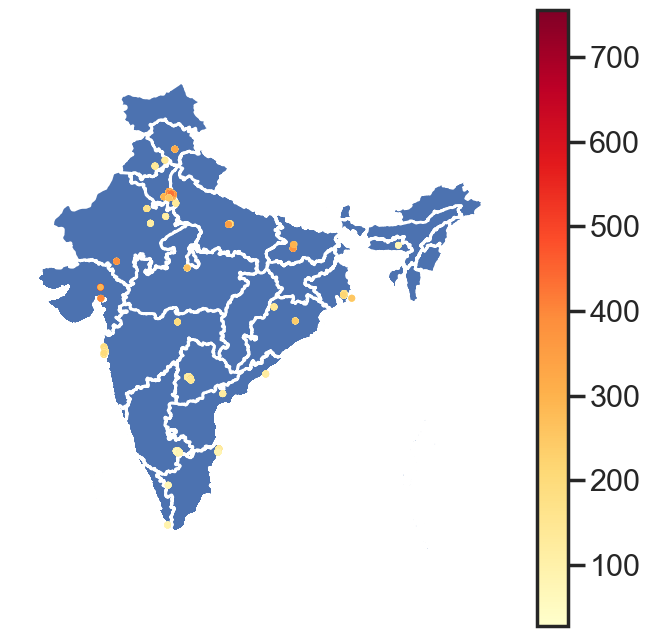

In [387]:
import geopandas as gpd
from pyproj import CRS

CRS_4326 = CRS('epsg:4326')

india_with_geo_month_mean_2019 = india_with_geo_month_mean_total.loc['2019']
india_with_geo_month_mean_2019['latitude'] = india_with_geo_month_mean_2019['StationId'].apply(
    lambda x: station_geo_map[x][0])
india_with_geo_month_mean_2019['longitude'] = india_with_geo_month_mean_2019['StationId'].apply(
    lambda x: station_geo_map[x][1])

latitude = india_with_geo_month_mean_2019.latitude
longitude = india_with_geo_month_mean_2019.longitude
india_with_geo_month_mean_2019_gdf = gpd.GeoDataFrame(india_with_geo_month_mean_2019,
                                                      geometry=gpd.points_from_xy(longitude, latitude), crs=CRS_4326)

fig, ax = plt.subplots(figsize=(8, 8))
india = gpd.read_file('shp/IND_adm1.shp')
india.plot(ax=ax)
india_with_geo_month_mean_2019_gdf.plot(markersize=8, ax=ax, column='AQI_Monthly_Mean', cmap='YlOrRd', legend=True)
ax.axis('off')

### 3. 平稳性与白噪声检验

In [357]:
def if_contains_month(df, year, month):
    for i in df.reset_index()['Date']:
        if i.year == year and i.month == month:
            return True

    return False


def last_day_of_month(month):
    if (month in [1, 3, 5, 7, 8, 10, 12]):
        return 31
    elif (month in [4, 6, 9, 11]):
        return 30
    else:
        return 28


final_map = {}
india_with_geo_station = india_with_geo[india_with_geo['StationId'] == 'BR007']
for year in ['2015', '2016', '2017', '2018', '2019', '2020']:
    if if_contains_year(india_with_geo_station, int(year)):
        for month in [i for i in range(1, 12)]:
            if if_contains_month(india_with_geo_station, int(year), int(month)):
                final_map[f'{year}-{month}-1'] = india_with_geo_station.loc[f'{year}-{month}'][:15]['AQI'].mean()
                final_map[f'{year}-{month}-{last_day_of_month(month)}'] = india_with_geo_station.loc[f'{year}-{month}'][15:]['AQI'].mean()

half_month_df = pd.DataFrame({'Date': final_map.keys(), 'AQI_Monthly_Mean': final_map.values()}).dropna()
half_month_df['Date'] = pd.to_datetime(half_month_df['Date'])
half_month_df = half_month_df.set_index('Date')
half_month_df

,AQI_Monthly_Mean
Date,
2015-06-01,124.040000
2015-06-30,146.400000
2015-07-01,127.106667
2015-07-31,116.075000
2015-08-01,131.906667
...,...
2020-05-01,179.749290
2020-05-31,179.749290
2020-06-01,195.779338


,StationId,AQI_Monthly_Mean,diff1,diff2
Date,,,,
2015-06-30,BR007,135.220000,35.220000,12.186667
2015-07-31,BR007,121.412903,-13.807097,-49.027097
2015-08-31,BR007,141.851613,20.438710,34.245806
2015-09-30,BR007,142.016619,0.165006,-20.273703
2015-10-31,BR007,206.101498,64.084879,63.919873
...,...,...,...,...
2020-03-31,BR007,160.638618,-74.500964,41.391713
2020-04-30,BR007,163.432860,2.794242,77.295206
2020-05-31,BR007,179.749290,16.316430,13.522188


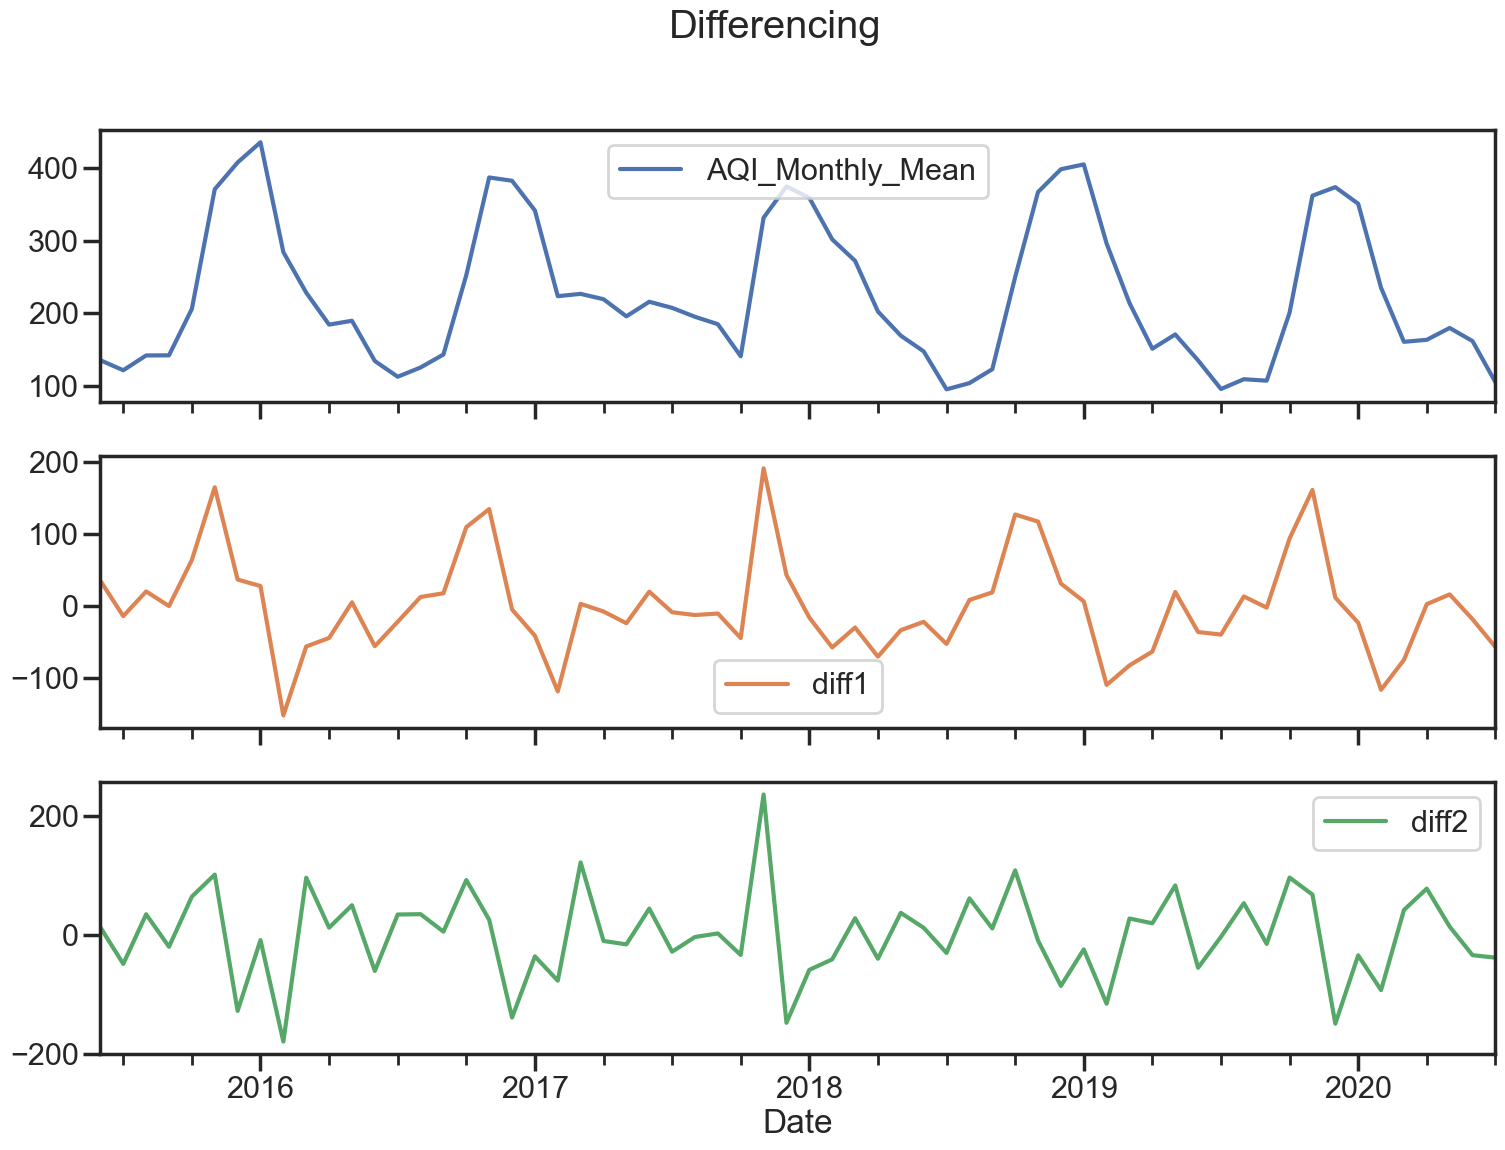

In [358]:
# 平滑处理：差分法
# ARIMA需要时间序列满足平稳性和非白噪声的要求
india_with_geo_month_mean_total["diff1"] = india_with_geo_month_mean_total["AQI_Monthly_Mean"].diff(1)
india_with_geo_month_mean_total["diff2"] = india_with_geo_month_mean_total["diff1"].diff(1)
data1 = india_with_geo_month_mean_total.loc[:, ["StationId","AQI_Monthly_Mean", "diff1", "diff2"]]
data1 = data1[data1['StationId']=="BR007"]
data1.plot(subplots=True, figsize=(18, 12), title="Differencing")

data1

In [359]:
import statsmodels.tsa.api as smt
import seaborn as sns

sns.set(style='ticks', context='poster')

data = data1['diff2'].dropna()

# data = india_with_geo[india_with_geo['StationId'] == 'BR007']
# data["diff1"] = data['AQI'].diff(1)
# data["diff2"] = data['diff1'].diff(1)
# data = data['diff2'].dropna()

print(data)


Date
2015-06-30    12.186667
2015-07-31   -49.027097
2015-08-31    34.245806
2015-09-30   -20.273703
2015-10-31    63.919873
                ...    
2020-03-31    41.391713
2020-04-30    77.295206
2020-05-31    13.522188
2020-06-30   -34.421123
2020-07-31   -38.539905
Name: diff2, Length: 62, dtype: float64


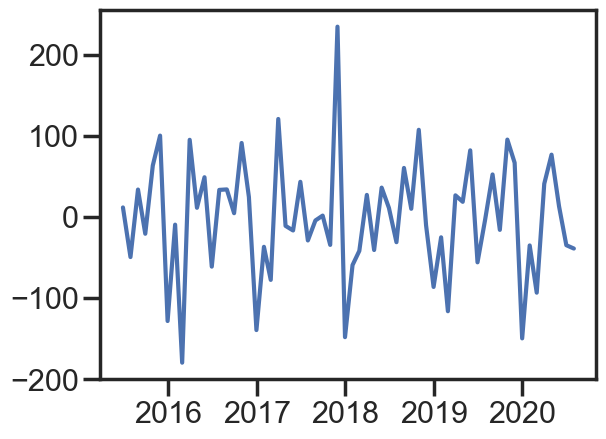

In [360]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plt.plot(data.index, data)
# plt.show()

In [361]:
# 平稳性检验
train = data.loc[:'2019/10/1']
test = data.loc['2019/10/1':]

# 1%、%5、%10不同程度拒绝原假设的统计值和ADF比较
# ADF同时小于1%、5%、10%即说明非常好地拒绝该假设
# 本数据中，adf结果为-1.25， 小于三个level的统计值，说明数据是平稳的
print(sm.tsa.stattools.adfuller(train))

(-6.248813350134017, 4.50653374113613e-08, 10, 41, {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}, 443.3322631903457)


In [362]:
# 白噪声检验
# acorr_ljungbox(train,lags=[6,12], boxpierce=True)
p_value = acorr_ljungbox(train, lags=1)
p_value

# 各阶延迟下LB和BP统计量的P值都小于显著水平0.05,
# 所以拒绝序列为纯随机序列的原假设，认为该序列为非白噪声序列

,lb_stat,lb_pvalue
1,3.440445,0.063619


### 4. ACF与PACF计算

Text(0.5, 1.0, 'ACF')

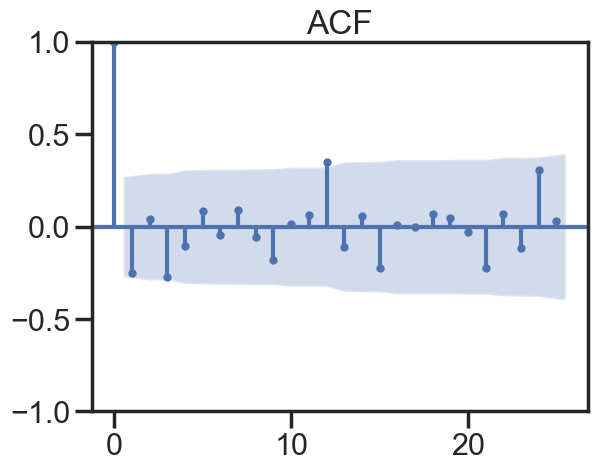

In [363]:
# 计算ACF
acf = plot_acf(train, lags=25)  # lags=10为往后滞后10个点，即下图中1+10=11个点
plt.title('ACF')

Text(0.5, 1.0, 'PACF')

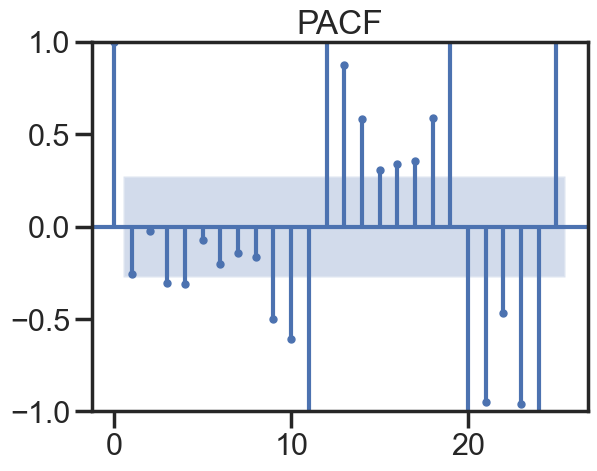

In [364]:
# PACF
smt.graphics.plot_pacf(train, lags=25)
plt.title("PACF")

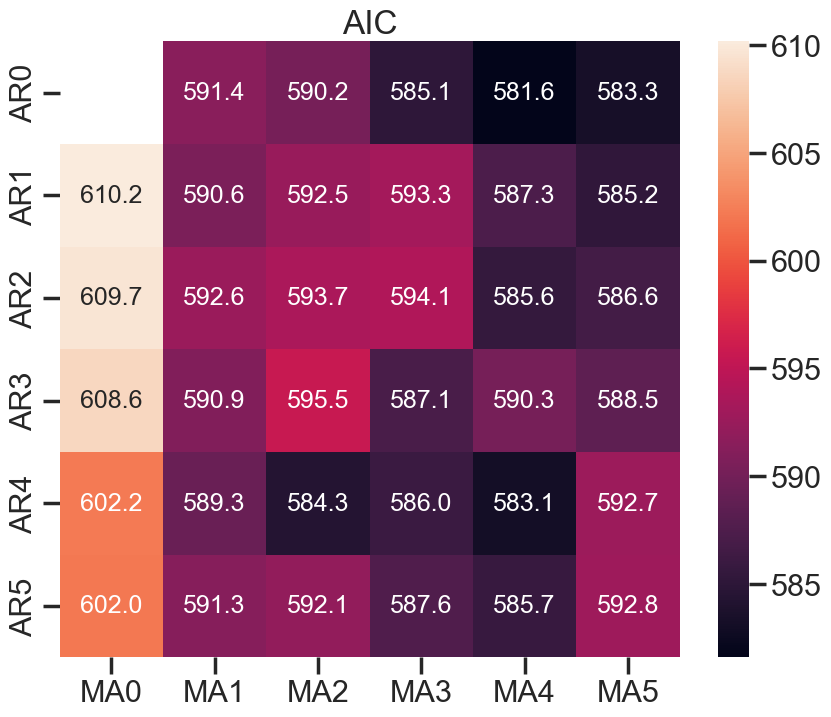

In [365]:
import itertools
import numpy as np


def heatmap_AIC(timeseries):
    #设置遍历循环的初始条件，以热力图的形式展示
    p_min = 0
    q_min = 0
    p_max = 5
    q_max = 5
    d_min = 0
    d_max = 1
    # 创建Dataframe,以AIC准则
    results_aic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min, p_max + 1)], \
                               columns=['MA{}'.format(i) for i in range(q_min, q_max + 1)])
    # itertools.product 返回p,q中的元素的笛卡尔积的元组
    for p, d, q in itertools.product(range(p_min, p_max + 1), range(d_min, d_max + 1), range(q_min, q_max + 1)):
        if p == 0 and q == 0:
            results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
            continue
        try:
            model = sm.tsa.ARIMA(timeseries, order=(p, d, q))
            results = model.fit()
            #返回不同pq下的model的AIC值
            results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.aic
        except:
            continue
    results_aic = results_aic[results_aic.columns].astype(float)
    #print(results_bic)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(results_aic,
                     #mask=results_aic.isnull(),
                     ax=ax,
                     annot=True,  # 将数字显示在热力图上
                     annot_kws={"fontsize": 18},  # 调整字体大小
                     fmt='.1f'
                     )
    ax.set_title('AIC')


heatmap_AIC(train)

### 5. 模型预测

In [366]:
# 从上面热力图看出 (AR2, MA5) (AR4, MA5) (AR5, MA5) => 其中AR对应p MA对应q 下面式子中
# 最终为何确定为(2, 0, 5) 可根据后面对模型进行评估来做比较，(2, 0, 5)的时候表现最佳
model = sm.tsa.arima.ARIMA(train, order=(4, 0, 4))  # order对应的参数为（p, d, q）
arima_res = model.fit()
arima_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  diff2   No. Observations:                   52
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -281.913
Date:                Sun, 12 Mar 2023   AIC                            583.826
Time:                        20:42:30   BIC                            603.339
Sample:                    06-30-2015   HQIC                           591.307
                         - 09-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3002      0.450     -0.668      0.504      -1.182       0.581
ar.L1         -0.4483      0.272     -1.647      0.100      -0.982       0.085
ar.L2          0.6477      0.428      1.513      0.130      -0.191       1.487
ar.L3          0.2489      0.335      0.743      0.458      -0.408       0.906
ar.L4         -0.5853      0.169     -3.468      0.001      -0.916      -0.255
ma.L1         -0.3091      8.844     -0.035      0.972     -17.642      17.024
ma.L2         -1.3895      6.068     -0.229      0.819     -13.282      10.503
ma.L3         -0.2335      6.457     -0.036      0.971     -12.890      12.423
ma.L4          0.9583      8.665      0.111      0.912     -16.025      17.942
sigma2      2972.7564   2.64e+04      0.113      0.910   -4.87e+04    5.46e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                32.04
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.98
Prob(H) (two-sided):                  0.17   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2019-10-31    26.335520
2019-11-30   -12.072247
2019-12-31   -19.246791
2020-01-31    16.169549
2020-02-29   -38.473955
2020-03-31    29.654340
2020-04-30   -23.265804
2020-05-31    10.257115
2020-06-30     9.888953
2020-07-31   -21.276546
Freq: M, Name: predicted_mean, dtype: float64
10
10


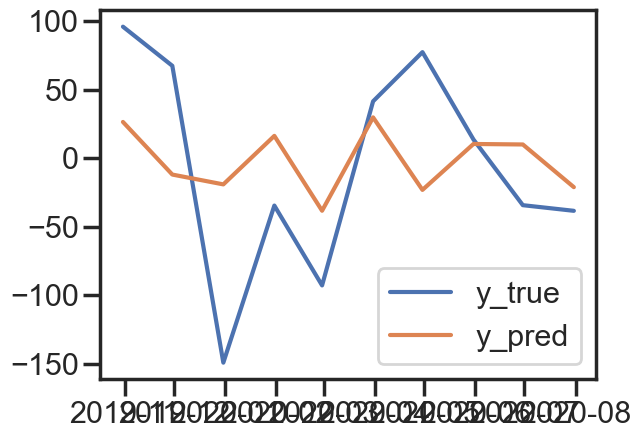

In [367]:
# 模型预测
predict = arima_res.predict('2019-10-1', '2020-7-1')
print(predict)
print(len(predict))
print(len(test))
plt.plot(test.index, test)
plt.plot(test.index, predict)
plt.legend(['y_true', 'y_pred'])
plt.show()

### 6. 模型评价

In [368]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mean_absolute_error(test, predict)
mean_squared_error(test, predict)
print('Mean absolute error', mean_absolute_error(test, predict))
print('Root mean square error', np.sqrt(mean_squared_error(test, predict)))
print('MAPE:', mean_absolute_percentage_error(test.ravel(), predict) * 100)



Mean absolute error 56.158610998470806
Root mean square error 67.93782808050372
MAPE: 83.89263394217681


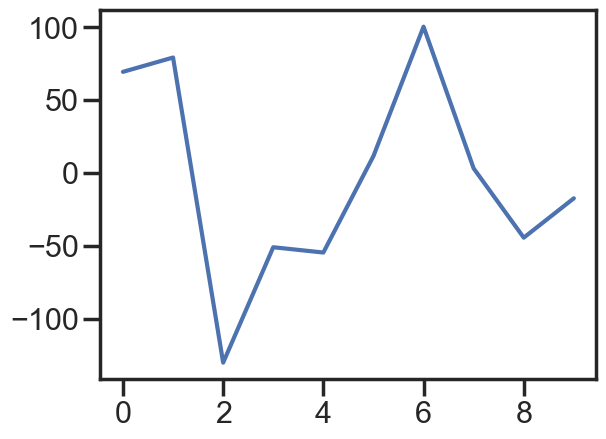

In [369]:
# 残差分析

res = test - predict
residual = list(res)
plt.plot(residual)


In [370]:
import numpy as np

# 查看残差的均值是否在0附近
np.mean(residual)

-3.261688421252906

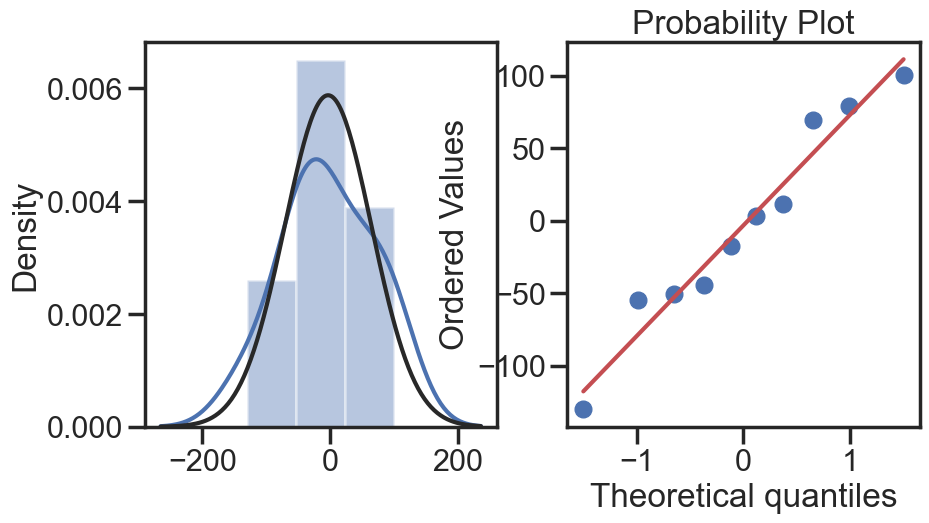

In [371]:
import seaborn as sns
from scipy import stats

# 残差正态性检验
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
sns.distplot(residual, fit=stats.norm)
ax = plt.subplot(1, 2, 2)
res = stats.probplot(residual, plot=plt)


134


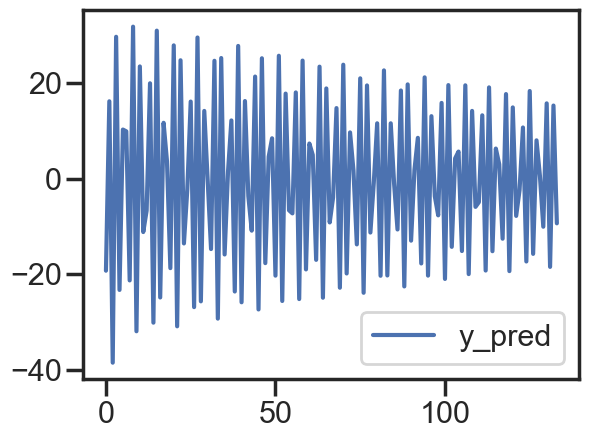

In [372]:
predict = arima_res.predict('2019/12/1', '2031/1/1')

# ARIMA不适用长期预测
# 如果将预测的时间调长，可以发现后面的预测值ARIMA基本都用均值来填充了
plt.plot(range(len(predict)), predict)
plt.legend(['y_pred'])
print(len(predict))

### 7. 神经网络 ANN

In [373]:
# MLPRegressor 做回归
# MLPClassifier 做分类 可以试试y为AQI_Bucket的时候做分类
from sklearn.neural_network import MLPRegressor, MLPClassifier

# 建立神经网络模型
# 这里也可以调一下参数看看不同的表现
mlp_model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10, 10), random_state=1)

In [374]:
from sklearn.model_selection import train_test_split

x_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
target_label = 'AQI'

# 神经网络预测这里才有以天为单位 这里和ARIMA不同
data = india_with_geo[india_with_geo['StationId'] == 'BR007']

train = data.loc[:'2020/1/1']
test = data.loc['2020/1/2':]
#
#     transfer = MinMaxScaler(feature_range=(0, 1))
#
#     # normalization
#     df_x = transfer.fit_transform(df_x)

# 不用train_test_split的原因:
# sklearn里这个函数可以帮助随机的分出训练集和测试集
# 但是随机的话会把时间顺序打乱

# 分训练集和测试集
x_train = train[x_columns]
y_train = train[target_label]
x_test = test[x_columns]
y_test = test[target_label]

print(len(x_train), len(x_test))

1676 182


In [375]:
# 调用fit函数就可以进行模型训练，一般的调用模型函数的训练方法都是fit()
mlp_model.fit(x_train, y_train)  # 训练

mlp_model

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(10, 10, 10), random_state=1,
             solver='lbfgs')

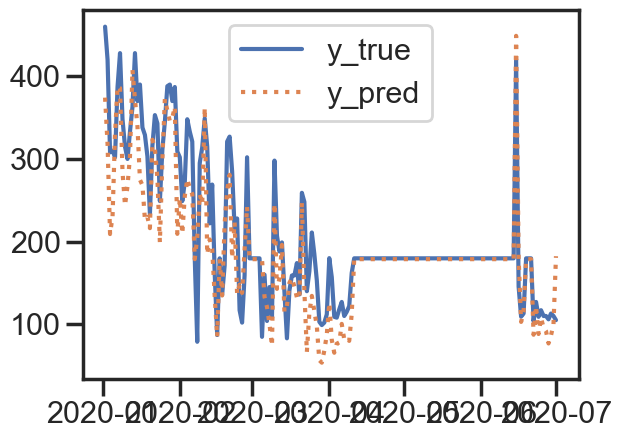

In [376]:
y_predict = mlp_model.predict(x_test)  # 预测

plt.plot(y_test.index, y_test)
plt.plot(y_test.index, y_predict, ':')
plt.legend(['y_true', 'y_pred'])

In [377]:
# print('训练集的层数为：', mlp_model.n_layers_)
# print('训练集的迭代次数', mlp_model.n_iter_)
# print('训练集的代价值是：', mlp_model.loss_)
# print('输出激活函数的名称', mlp_model.out_activation_)

print('r2：', mlp_model.score(x_test, y_test.ravel()))
print('Root mean square error', np.sqrt(mean_squared_error(y_test.ravel(), y_predict)))
print('Mean absolute error', mean_absolute_error(y_test.ravel(), y_predict))
print('MAPE:', mean_absolute_percentage_error(y_test.ravel(), y_predict) * 100)

r2： 0.7677865833478908
Root mean square error 40.958747670676246
Mean absolute error 26.318471175317946
MAPE: 13.598954281368394
